<a href="https://colab.research.google.com/github/alexlapshov89/ALapshov_coding/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект: классификация

In [66]:
# Устанавливаем библиотеку
#!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 8.5 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 209 kB 51.6 MB/s 
     |████████████████████████████████| 78 kB 2.8 MB/s 
     |████████████████████████████████| 147 kB 50.7 MB/s 
     |████████████████████████████████| 112 kB 14.2 MB/s 
     |████████████████████████████████| 49 kB 2.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=744538d20f68f4464a5c232e547ca5725d247ababc174f03854cd45a274a5956
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [67]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import chi2
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Skillfactory/ML-Project/data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
display(df.info())
print('\n Информация о пропусках \n')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None


 Информация о пропусках 



age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

**Описание признаков:**

age (возраст);

job (сфера занятости);

marital (семейное положение);

education (уровень образования);

default (имеется ли просроченный кредит);

housing (имеется ли кредит на жильё);

loan (имеется ли кредит на личные нужды);

balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

contact (тип контакта с клиентом);

month (месяц, в котором был последний контакт);

day (день, в который был последний контакт);

duration (продолжительность контакта в секундах).

Прочие признаки:

campaign (количество контактов с этим клиентом в течение текущей кампании);

pdays (количество пропущенных дней с момента последней маркетинговой кампании 
до контакта в текущей кампании);

previous (количество контактов до текущей кампании)

poutcome (результат прошлой маркетинговой кампании)

deposit (наличие счета в банке) - целевая переменная

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# функция преобразования строки в вещественное число:
def get_balance(string):
  try:
    regex = r'\d+|\-\d+'
    number_str_list = re.findall(regex,string)
    number_str = ''.join(number_str_list[0:-1])+'.'+number_str_list[-1]
    number_float = float(number_str)
    return number_float
  except TypeError:
    pass
# преобразование признака 'balance':

df['balance'] = df['balance'].apply(get_balance)
print('Среднее значение баланса клиентов: ',df['balance'].mean())

Среднее значение баланса клиентов:  1529.1290293615875


### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
print('После заполнения пропусков в признаке "баланс" их число составило: ',df['balance'].isnull().sum())
print('Среднее значение баланса клиентов: ',df['balance'].mean())

После заполнения пропусков в признаке "баланс" их число составило:  0
Среднее значение баланса клиентов:  1526.9360329690019


### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
most_popular_job = df['job'].value_counts().index[0]
df['job'] = df['job'].apply(lambda x: most_popular_job if x=='unknown' else x)
most_popular_education = df['education'].value_counts().index[0]
df['education'] = df['education'].apply(lambda x: most_popular_education if x=='unknown' else x)
mask = (df['job']==most_popular_job)&(df['education']==most_popular_education)
print('Средний баланс клиентов с самой популярной работой и самым популярным уровнем образования: ',df[mask].balance.mean())

Средний баланс клиентов с самой популярной работой и самым популярным уровнем образования:  1598.8829787234042


### Задание 6

In [9]:
# удалите все выбросы для признака balance

# функция очистки датасета по методу Тьюки для признака feature
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>=lower_bound) & (x<=upper_bound)]
    return {'outliers':outliers, 'cleaned':cleaned, 'lower_bound':lower_bound,'upper_bound':upper_bound}

dict_outl_iqr = outliers_iqr(df,'balance')
print('Нижняя граница по методу Тьюки: ',dict_outl_iqr['lower_bound'])
print('Верхняя граница по методу Тьюки: ',dict_outl_iqr['upper_bound'])
df = dict_outl_iqr['cleaned']
print ('После очистки выбросов по методу Тьюки осталось строк: ',df.shape[0])



Нижняя граница по методу Тьюки:  -2241.0
Верхняя граница по методу Тьюки:  4063.0
После очистки выбросов по методу Тьюки осталось строк:  10105


## Часть 2:  Разведывательный анализ

### Задание 1

Число клиентов, открывших депозит:  4681


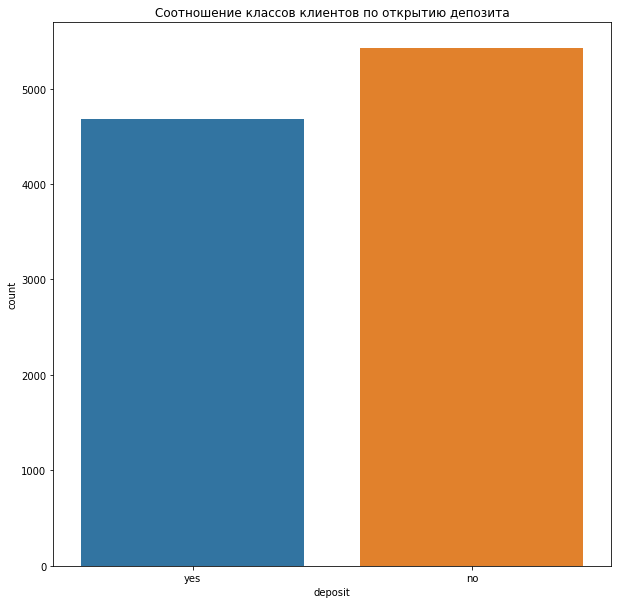

In [10]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig = plt.figure(figsize=(10,10))
fig = sns.countplot(df['deposit'])
fig.set_title('Соотношение классов клиентов по открытию депозита')
print ('Число клиентов, открывших депозит: ',df[df['deposit']=='yes'].shape[0])

### Задания 2 и 3

In [11]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


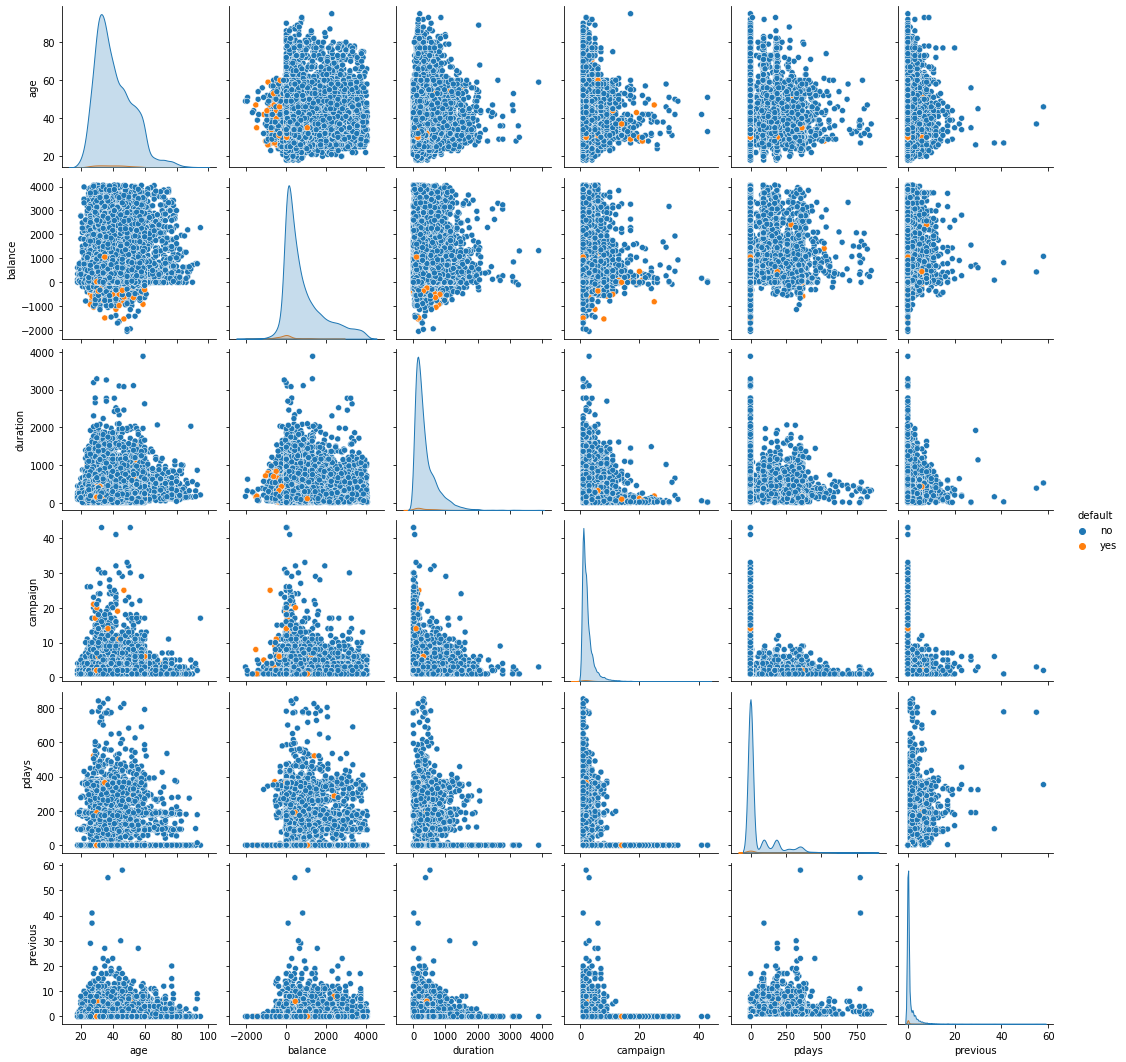

In [12]:
sns.pairplot(df.drop(columns=['day']),hue='default')

df.pairplot()

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


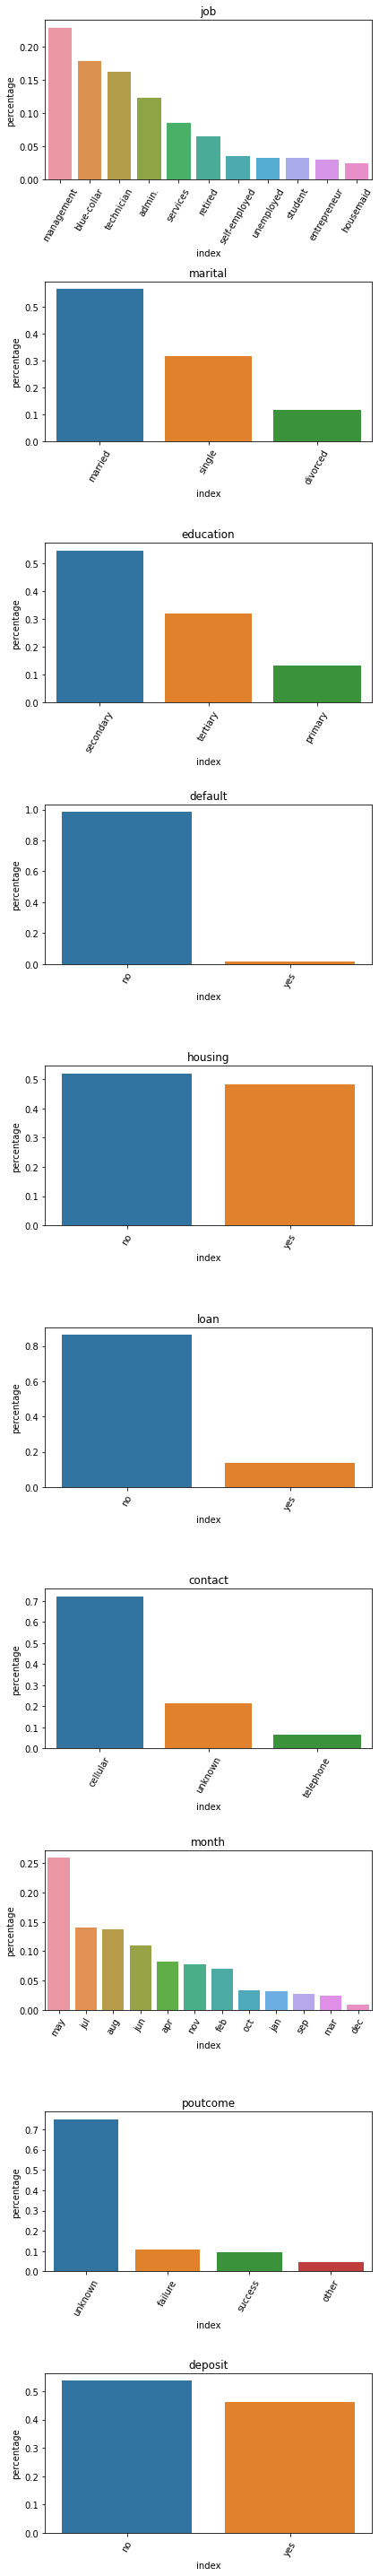

In [13]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
display(df.describe(include=['object']))
#постройте визуализации, иллюстрирующие результаты
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 1, figsize=(6, 40)) #фигура+2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i])
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(feature)
plt.tight_layout() #выравнивание графиков

### Задание 6

Text(0.5, 1.0, 'Результаты прошлой маркетинговой компании в срезе нынешней')

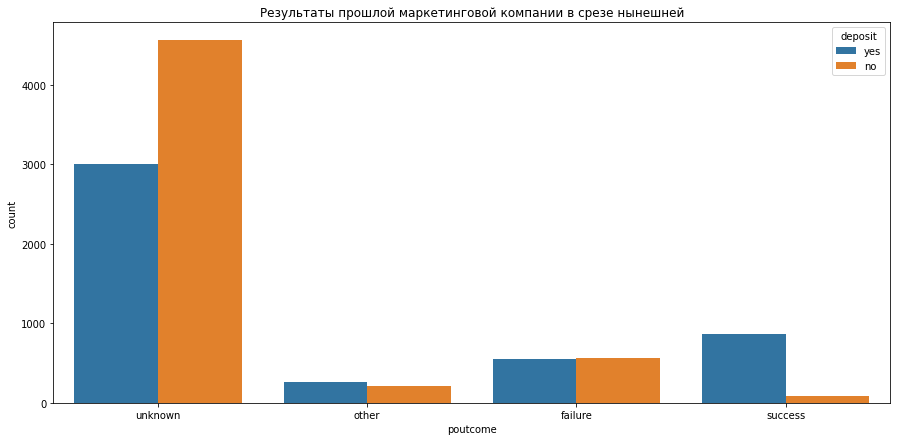

In [14]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
fig = plt.figure(figsize=(15,7))
fig = sns.countplot(data=df,x='poutcome',hue='deposit')
fig.set_title('Результаты прошлой маркетинговой компании в срезе нынешней')


### Задание 7

Text(0.5, 1.0, 'Результаты маркетинговой компании по месяцам')

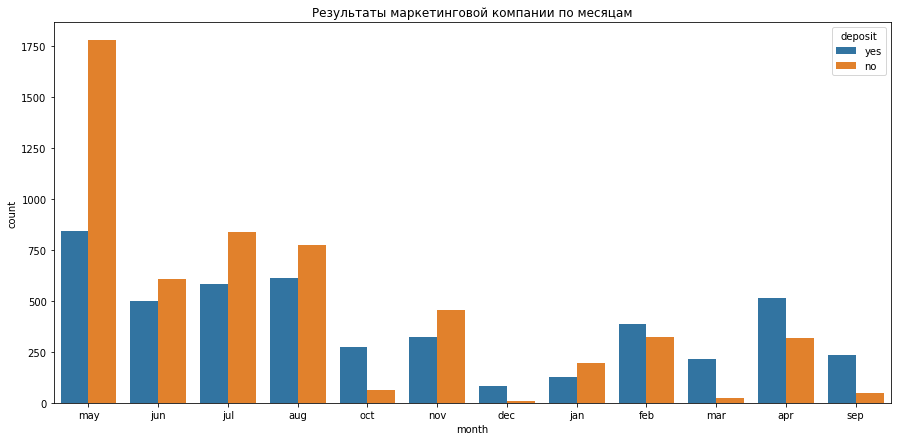

In [15]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
fig = plt.figure(figsize=(15,7))
fig = sns.countplot(data=df,x='month',hue='deposit')
fig.set_title('Результаты маркетинговой компании по месяцам')


### Задание 8

Text(0.5, 1.0, 'Результаты маркетинговой компании по возрастным группам')

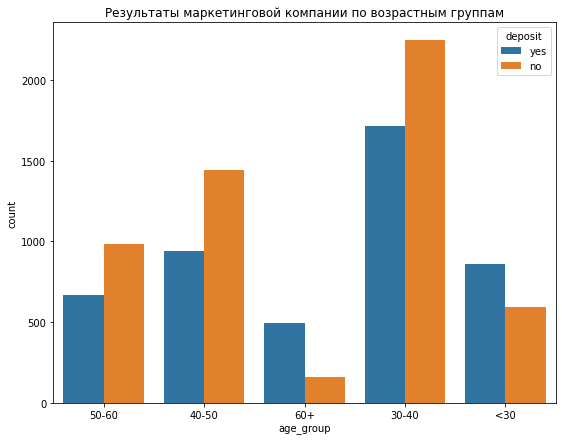

In [16]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

# функция определения возрастной группы
def get_age_group(age):
  if age<30:
    age_group = '<30'
  elif 30<=age<40:
    age_group = '30-40'
  elif 40<=age<50:
    age_group = '40-50'
  elif 50<=age<60:
    age_group = '50-60'
  elif age>=60:
    age_group = '60+'
  return age_group  

df['age_group'] = df['age'].apply(get_age_group)
fig = plt.figure(figsize=(9,7))
fig = sns.countplot(data=df,x='age_group',hue='deposit')
fig.set_title('Результаты маркетинговой компании по возрастным группам')

### Задания 9 и 10

Text(0.5, 1.0, 'Результаты маркетинговой компании по семейному статусу')

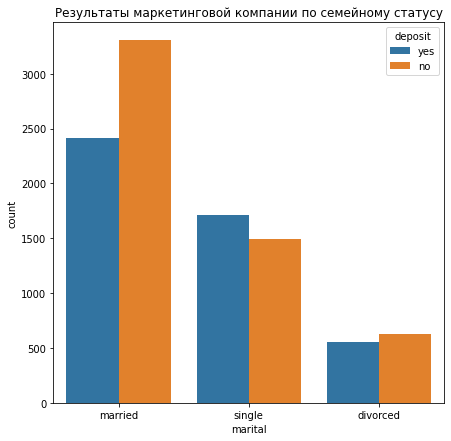

In [17]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = plt.figure(figsize=(7,7))
fig = sns.countplot(data=df,x='marital',hue='deposit')
fig.set_title('Результаты маркетинговой компании по семейному статусу')

Text(0.5, 1.0, 'Результаты маркетинговой компании по уровню образования')

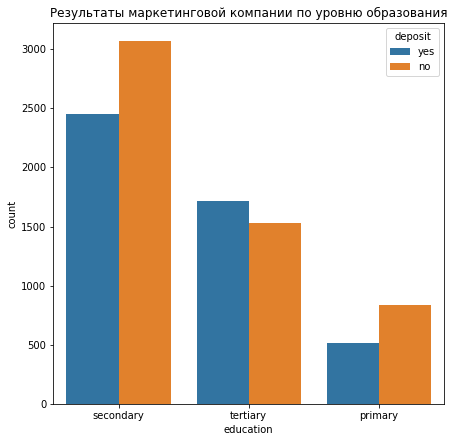

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = plt.figure(figsize=(7,7))
fig = sns.countplot(data=df,x='education',hue='deposit')
fig.set_title('Результаты маркетинговой компании по уровню образования')

Text(0.5, 1.0, 'Результаты маркетинговой компании по сфере занятости')

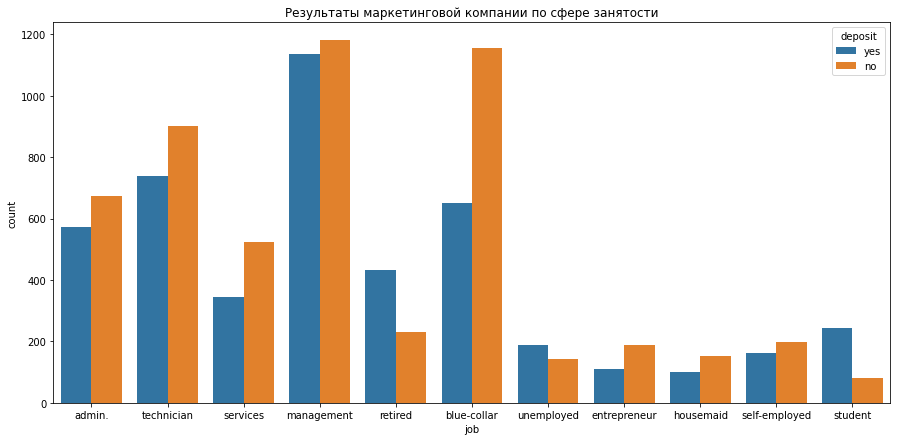

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = plt.figure(figsize=(15,7))
fig = sns.countplot(data=df,x='job',hue='deposit')
fig.set_title('Результаты маркетинговой компании по сфере занятости')

### Задание 11

Text(0.5, 1.0, 'Не открыли депозит')

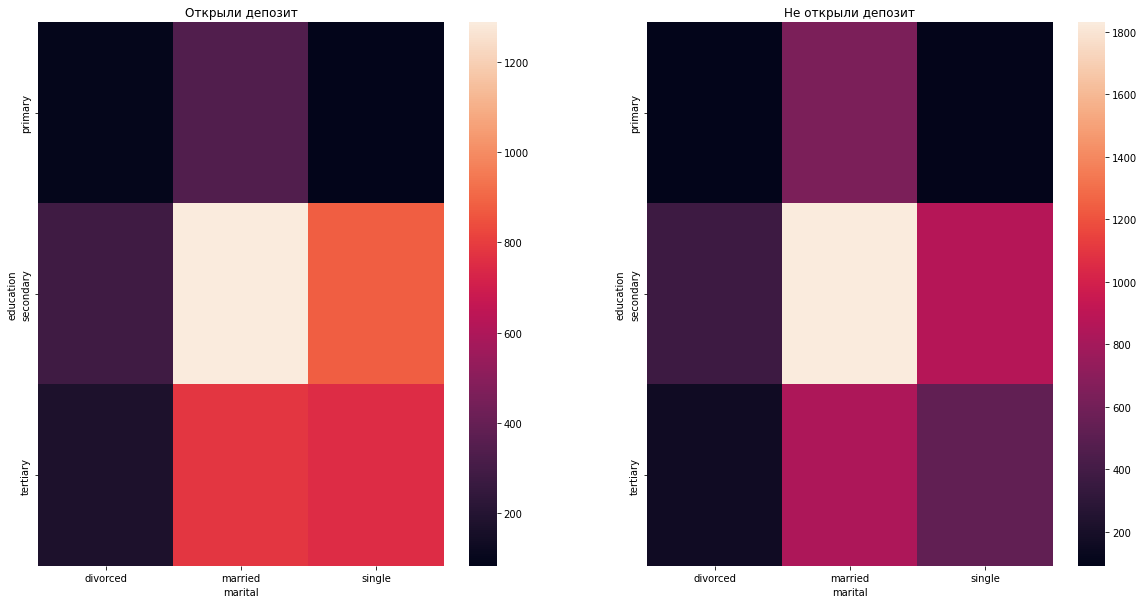

In [20]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

df_dep_true = df[df['deposit']=='yes']
df_dep_false = df[df['deposit']=='no']

pivot_dep_true = df_dep_true.pivot_table(values='deposit',index='education',columns='marital',aggfunc='count')
pivot_dep_false = df_dep_false.pivot_table(values='deposit',index='education',columns='marital',aggfunc='count')
fig,axes = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(pivot_dep_true,ax=axes[0])
sns.heatmap(pivot_dep_false,ax=axes[1])
axes[0].set_title('Открыли депозит')
axes[1].set_title('Не открыли депозит')

## Часть 3: преобразование данных

### Задание 1

In [21]:
# кодирование признака 'education'
le = LabelEncoder()
education = le.fit_transform(df['education'])
education = pd.Series(education,name='education_int')
df = pd.concat([df.reset_index(),education],axis=1)
df = df.drop(columns=['education'])
df = df.drop(columns=['index'])

In [22]:
df['education_int'].sum()

11995

In [23]:
# кодирование признака 'age_group'
age = le.fit_transform(df['age_group'])
age = pd.Series(age,name='age_int')
df = pd.concat([df,age],axis=1)
df = df.drop(columns=['age','age_group'])

### Задания 2 и 3

In [24]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [25]:
df['deposit'].std()

0.4986712532452124

In [26]:
df['default'].mean()+df['housing'].mean()+df['loan'].mean()

0.6354280059376547

In [27]:
df.shape

(10105, 17)

### Задание 4

In [28]:
# создайте дамми-переменные
df = pd.get_dummies(df,columns=['job','marital','contact','month','poutcome'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   default            10105 non-null  int64  
 1   balance            10105 non-null  float64
 2   housing            10105 non-null  int64  
 3   loan               10105 non-null  int64  
 4   day                10105 non-null  int64  
 5   duration           10105 non-null  int64  
 6   campaign           10105 non-null  int64  
 7   pdays              10105 non-null  int64  
 8   previous           10105 non-null  int64  
 9   deposit            10105 non-null  int64  
 10  education_int      10105 non-null  int64  
 11  age_int            10105 non-null  int64  
 12  job_admin.         10105 non-null  uint8  
 13  job_blue-collar    10105 non-null  uint8  
 14  job_entrepreneur   10105 non-null  uint8  
 15  job_housemaid      10105 non-null  uint8  
 16  job_management     101

### Задания 5 и 6

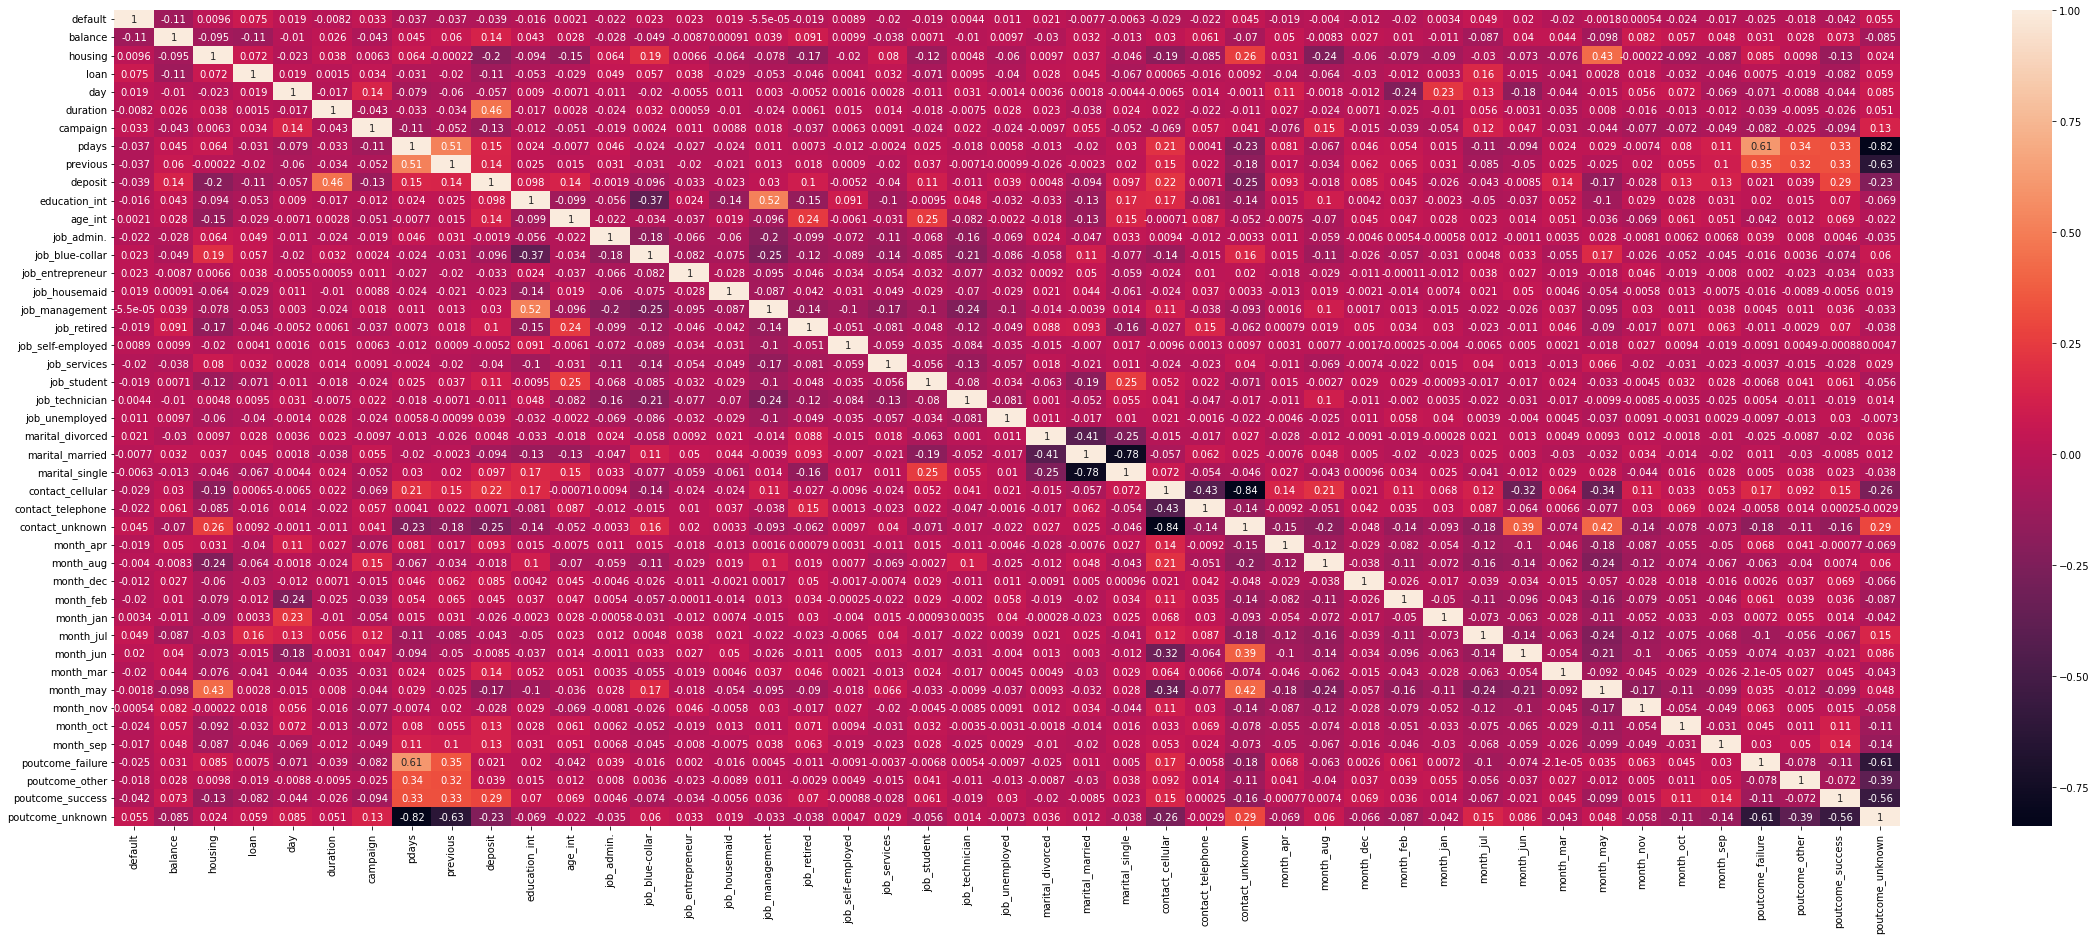

In [30]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig = plt.figure(figsize=(40,15))
sns.heatmap(df.corr(),annot=True)

### Задания 7 и 8

In [31]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [32]:
# рассчитайте необходимые показатели
print('Размер тестовой выборки: ',X_test.shape[0])
print('Среднее значение целевой переменной на тестовой выборке: ',y_test.mean())

Размер тестовой выборки:  3335
Среднее значение целевой переменной на тестовой выборке:  0.46326836581709147


### Задание 9

In [33]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
select_columns = selector.get_feature_names_out()
select_columns

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_int', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [34]:
X_train = X_train[select_columns]
X_test = X_test[select_columns]

### Задание 10

In [35]:
# нормализуйте данные с помощью minmaxsxaler
col_names = ['balance','duration','campaign','pdays','previous',]
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[col_names] = scaler.fit_transform(X_train[col_names])
X_test_scaled[col_names] = scaler.transform(X_test[col_names])


In [36]:
X_train_scaled['balance'].mean()

0.46696454464955495

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [37]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42,solver='sag',max_iter=1000)
log_reg.fit(X_train_scaled,y_train)
y_pred = log_reg.predict(X_test_scaled)
print(metrics.accuracy_score(y_pred,y_test))

0.8047976011994002


### Задания 2,3,4

In [38]:
# обучите решающие деревья, настройте максимальную глубину

# обучение и значение метрики. Максимальная глубина не ограничена
dt = tree.DecisionTreeClassifier(criterion='entropy',random_state=42)
dt.fit(X_train_scaled,y_train)
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
print(metrics.accuracy_score(y_train_pred,y_train))
print(metrics.accuracy_score(y_test_pred,y_test))
# обучение и значения метрики. Максимальная глубина перебирается от 1 до 19
accuracy_train = []
accuracy_test = []
for max_depth in range(1,20):
  dt = tree.DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=max_depth)
  dt.fit(X_train_scaled,y_train)
  y_train_pred = dt.predict(X_train_scaled)
  y_test_pred = dt.predict(X_test_scaled)
  accuracy_train.append(round(metrics.accuracy_score(y_train_pred,y_train),2))
  accuracy_test.append(round(metrics.accuracy_score(y_test_pred,y_test),2))
print(accuracy_train)
print(accuracy_test)
#fig = plt.figure(figsize=(10,10))
#fig = plt.kind()



1.0
0.7472263868065967
[0.71, 0.73, 0.78, 0.78, 0.8, 0.82, 0.84, 0.84, 0.85, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96]
[0.71, 0.72, 0.77, 0.77, 0.79, 0.81, 0.82, 0.81, 0.81, 0.8, 0.79, 0.79, 0.79, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77]


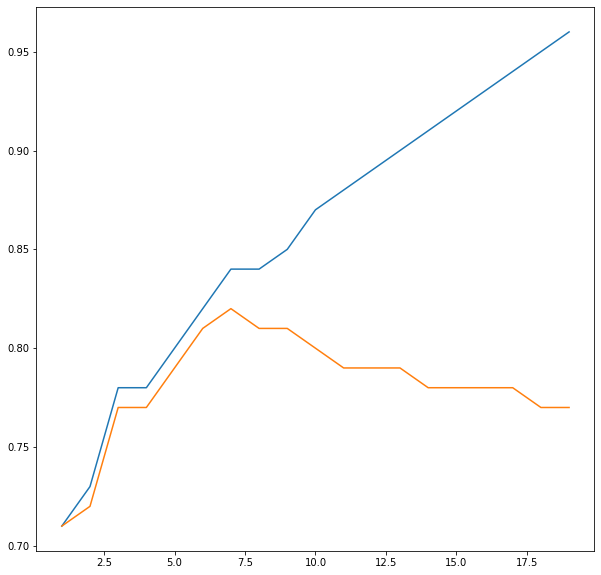

In [39]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(range(1,20),accuracy_train)
ax.plot(range(1,20),accuracy_test)


### Задание 5

In [40]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'max_depth': [3,5,7] ,# максимальная глубина
              'min_samples_split':[2, 5, 7, 10] # число объектов в листе
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
#print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 301 ms, sys: 90.3 ms, total: 391 ms
Wall time: 2.77 s
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [54]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(n_estimators=100,criterion='gini',min_samples_leaf=5,max_depth=10,random_state=42)
rf.fit(X_train_scaled,y_train)
y_pred = rf.predict(X_test_scaled)
#print('accuracy на тестовом наборе: ', round(metrics.accuracy_score(y_pred,y_test),2))
#print('recall на тестовом наборе: ', round(metrics.recall_score(y_pred,y_test),2))
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1728
           1       0.83      0.80      0.82      1607

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [55]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = GradientBoostingClassifier(
    learning_rate=0.05,
    min_samples_leaf=5,
    max_depth=5,
    n_estimators=300,
    random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred  = gb.predict(X_test_scaled)
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1731
           1       0.83      0.80      0.82      1604

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [58]:
# объедините уже известные вам алгоритмы с помощью стекинга 

#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', linear_model.LogisticRegression(random_state=42,solver='sag',max_iter=1000)),
    ('dt', tree.DecisionTreeClassifier(criterion='entropy',max_depth=7,min_samples_split=10,random_state=42)),
    ('rf', ensemble.RandomForestClassifier(n_estimators=100,criterion='gini',min_samples_leaf=5,max_depth=10,random_state=42)),
    ('gb', GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=5, max_depth=5, n_estimators=300, random_state=42))
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
#Обучаем модель
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
print(metrics.precision_score(y_pred,y_test))

0.8174757281553398


### Задание 5

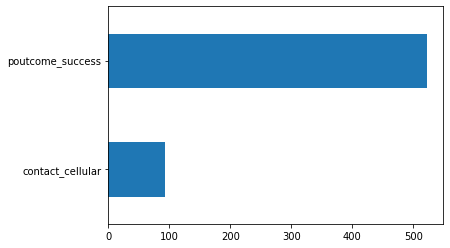

In [64]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

cat_cols = ['contact_cellular','poutcome_success']
imp_cat = pd.Series(chi2(X_train_scaled[cat_cols], y_train)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### Задания 6,7,8

In [68]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [72]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2022-09-26 18:01:05,259] A new study created in memory with name: RandomForestClassifier
[I 2022-09-26 18:01:08,076] Trial 0 finished with value: 0.8444374607165306 and parameters: {'n_estimators': 182, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8444374607165306.
[I 2022-09-26 18:01:08,873] Trial 1 finished with value: 0.8524744697564808 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8524744697564808.
[I 2022-09-26 18:01:10,045] Trial 2 finished with value: 0.8616155291170945 and parameters: {'n_estimators': 170, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8616155291170945.
[I 2022-09-26 18:01:10,805] Trial 3 finished with value: 0.845065996228787 and parameters: {'n_estimators': 124, 'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.8616155291170945.
[I 2022-09-26 18:01:11,809] Trial 4 finished with value: 0.8579927978706747 and parameters: {'n_

CPU times: user 48.2 s, sys: 216 ms, total: 48.4 s
Wall time: 49.5 s


In [73]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
print(metrics.classification_report(y_pred,y_test))
#print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1763
           1       0.82      0.80      0.81      1572

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

